Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


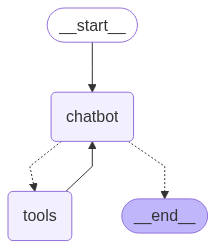

質問: aから始まるえいたんごを10こあげて
aから始まるえいたんごを10こあげて
以下は「a」から始まる英単語のリストです：

1. Apple（リンゴ）
2. Animal（動物）
3. Airplane（飛行機）
4. Artist（アーティスト）
5. Adventure（冒険）
6. Amazing（驚くべき）
7. Alphabet（アルファベット）
8. Agreement（合意）
9. Athlete（アスリート）
10. Atmosphere（大気）

これらの単語はさまざまな意味を持ち、日常的に使われるものです。
質問: 5ばんめは何
5ばんめは何
5番目の単語は「Adventure（冒険）」です。
質問: 3ばんめは何
3ばんめは何
3番目の単語は「Airplane（飛行機）」です。


In [ ]:
# 必要なモジュールをインポート
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from typing import Annotated
from typing_extensions import TypedDict
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

# ===== Stateクラスの定義 =====
class State(TypedDict):
    messages: Annotated[list, add_messages]

# ===== グラフの構築 =====
def build_graph(model_name):
    # ソースコードを記述

    # 検索ツールの定義
    from langchain_community.tools.tavily_search import TavilySearchResults

    tool = TavilySearchResults(max_results=2)
    tools = [tool]

    # ステートグラフの作成
    graph_builder = StateGraph(State)

    # チャットモデルの作成
    llm = ChatOpenAI(model=model_name, temperature=0)
    # ツールと紐づけ
    llm_with_tools = llm.bind_tools(tools)
    

    # チャットボットノードの作成
    def chatbot(state: State):
      return {"messages": [llm_with_tools.invoke(state["messages"])]}
    graph_builder.add_node("chatbot", chatbot)

    # ツールノードの作成
    tool_node = ToolNode(tools)
    graph_builder.add_node("tools",tool_node)

    # 条件付エッジの作成
    graph_builder.add_conditional_edges(
      "chatbot",
      tools_condition, # ツール呼出と判断したらツールノードを呼ぶ
    )

    # ツールが呼び出されるたびに、チャットボットに戻って次のステップを決定
    # ツールからチャットボットへの戻りエッジを作成
    graph_builder.add_edge("tools", "chatbot")

    # 開始ノードの指定
    graph_builder.set_entry_point("chatbot")

    # 記憶を持つ実行可能なステートグラフの作成
    memory = MemorySaver()
    graph = graph_builder.compile(checkpointer=memory)

    # 開始ノードの作成
    graph_builder.set_entry_point("chatbot")

    # 記憶を持つ実行可能なステートグラフの作成
    memory = MemorySaver()
    graph = graph_builder.compile(checkpointer=memory)

    # グラフの可視化
    from IPython.display import Image, display

    display(Image(graph.get_graph().draw_mermaid_png()))

    return graph

    

# ===== グラフ実行関数 =====
def stream_graph_updates(graph: StateGraph, user_input: str):
    # ソースコードを記述
    events = graph.stream(
        {"messages": [("user", user_input)]},
        {"configurable": {"thread_id": "1"}},
        stream_mode="values")
    # 結果をストリーミングで得る
    for event in events:
        print(event["messages"][-1].content, flush=True)


# ===== メイン実行ロジック =====
# 環境変数の読み込み
load_dotenv("../.env")
os.environ['OPENAI_API_KEY'] = os.environ['API_KEY']

# モデル名
MODEL_NAME = "gpt-4o-mini" 

# グラフの作成
# ソースコードを記述
graph = build_graph(MODEL_NAME)

# メインループ
# ソースコードを記述
while True:
    user_input = input("質問:")
    if user_input.strip()=="":
        print("ありがとうございました!")
        break
    print("質問:", user_input, flush=True)
    stream_graph_updates(graph, user_input)